In [13]:
import requests
import datetime
import json
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
sample_text = """Competition
The pharmaceutical and biotechnology industries are characterized by rapidly advancing technologies, intense
competition and a strong emphasis on proprietary drugs. While we believe that our technology, development experience and
scientific knowledge provide us with competitive advantages, we face potential competition from many different sources,
including major pharmaceutical, specialty pharmaceutical and biotechnology companies, academic institutions and
governmental agencies and public and private research institutions. Any drug candidates that we successfully develop and
commercialize will compete with existing drugs and new drugs that may become available in the future.
We compete in the segments of the pharmaceutical, biotechnology and other related markets that address inhibition
of kinases in cancer and other rare genetic diseases. There are other companies working to develop therapies in the field of
kinase inhibition for cancer and other diseases. These companies include divisions of large pharmaceutical companies and
biotechnology companies of various sizes.
Many of the companies against which we are competing or against which we may compete in the future have
significantly greater financial resources and expertise in research and development, manufacturing, pre-clinical testing,
acquisitions in the pharmaceutical, biotechnology and diagnostic industries may result in even more resources being
concentrated among a smaller number of our competitors. Smaller or early stage companies may also prove to be significant
competitors, particularly through collaborative arrangements with large and established companies. These competitors also
compete with us in recruiting and retaining qualified scientific and management personnel and establishing clinical trial
sites and patient registration for clinical trials, as well as in acquiring technologies complementary to, or necessary for, our
programs.
Our commercial opportunity could be reduced or eliminated if our competitors develop and commercialize drugs
that are safer, more effective, have fewer or less severe side effects, are more convenient or are less expensive than any drugs
that we or our collaborators may develop. Our competitors also may obtain FDA or other regulatory approval for their drugs
more rapidly than we may obtain approval for ours, which could result in our competitors establishing a strong market
position before we or our collaborators are able to enter the market. The key competitive factors affecting the success of all of
our drug candidates, if approved, are likely to be their efficacy, safety, convenience, price, the effectiveness of companion
diagnostic tests in guiding the use of related therapeutics, the level of generic competition and the availability of
reimbursement from government and other third‑party payors.
If our drug candidates are approved for the indications for which we are currently conducting or planning clinical
trials, they will compete with the drugs discussed below and will likely compete with other drugs that are currently in
development.
avapritinib
We are initially developing avapritinib for advanced GIST and for SM, including advanced SM and indolent and
smoldering SM. If avapritinib receives marketing approval for advanced SM, it will face competition from Novartis AG’s
midostaurin, a multi-kinase inhibitor with KIT D816V inhibitory activity that was approved in April 2017 by the FDA for the
treatment of advanced SM. If avapritinib receives marketing approval for third line advanced GIST, it will face competition
from Bayer AG’s regorafenib, and if avapritinib receives marketing approval for second line advanced GIST, it will face
competition from Pfizer Inc.’s sunitinib. In addition, if avapritinib receives marketing approval for advanced SM, GIST
and/or for GIST patients with the PDGFRA D842V mutation, it may face competition from other drug candidates in
development for these indications, including drug candidates in development by AB Science S.A., Allakos Inc., ARIAD
Pharmaceuticals, Inc., a wholly-owned subsidiary of Takeda Pharmaceutical Company Limited, AROG Pharmaceuticals, Inc.,
Celldex Therapeutics, Inc., and Deciphera Pharmaceuticals, LLC.
BLU‑667
We are initially developing BLU‑667 for patients with RET-altered NSCLC, MTC and other advanced solid tumors.
If BLU‑667 receives marketing approval for patients with RET-driven cancers, it may face competition from other drug
candidates in development, including drug candidates in development by ARIAD Pharmaceuticals, Inc., a wholly-owned
subsidiary of Takeda Pharmaceutical Company Limited, AstraZeneca plc, Boston Pharmaceuticals, Inc., Eisai Inc., Exelixis,
Inc., GlaxoSmithKline plc, Loxo Oncology, Inc., a wholly-owned subsidiary of Eli Lilly and Company, Mirati Therapeutics,
Inc., Novartis AG, Pfizer Inc. and Roche, as well as several approved multi-kinase inhibitors with RET activity being
evaluated in clinical trials, including alectinib, apatinib, cabozantinib, dovitinib, lenvatinib, ponatinib, sorafenib, sunitinib
and vandetinib.
BLU‑554
We are initially developing BLU‑554 for patients with advanced HCC driven by FGFR4. If BLU-554 receives
marketing approval for patients with FGFR4-activated HCC, it will face competition from Bristol-Myers Squibb Company’s
nivolumab and Merck & Co., Inc.’s pembrolizumab, immune checkpoint inhibitors approved by the FDA for the treatment of
HCC, as well as sorafenib, cabozantinib, regorafenib and lenvatinib, multi-kinase inhibitors approved for the treatment of
HCC. In addition, BLU-554 may face competition from other drug candidates in development by Abbisko Therapeutics Co.,
Ltd, AstraZeneca plc, Bayer AG, Celgene Corporation, Eisai Inc., H3 Biomedicine Inc., Incyte Corporation, Johnson &
Johnson, Novartis AG, Sanofi S.A., Taiho Pharmaceutical Co., Ltd., U3 Pharma GmbH, a wholly-owned subsidiary of Daiichi
Sankyo Company, Limited, and Xoma Ltd.
BLU‑782
We are initially developing BLU‑782 for patients with FOP. If BLU-782 receives marketing approval for FOP, it may
face competition from drug candidates in development by BioCryst Pharmaceuticals, Inc., Clementia Pharmaceuticals Inc.,
La Jolla Pharmaceutical Company and Regeneron Pharmaceuticals, Inc.
 """

In [14]:
# helper function
def _convert_epoch_to_datetime(epoch_seconds):
    epoch = datetime.datetime(1970, 1, 1)
    dt = epoch + datetime.timedelta(seconds=epoch_seconds)
    return dt.replace(hour=0, minute=0, second=0, microsecond=0)


def _convert_datetime_to_epoch(start):
    dt = pd.to_datetime(start)
    epoch = datetime.datetime(1970, 1, 1)
    return int((dt - epoch).total_seconds())

In [24]:
def get_historical_prices(ticker=None, start_date=datetime.datetime(2010, 1, 1), end_date=datetime.datetime.now()):
    # convert datetimes to epoch
    dstart_secs = _convert_datetime_to_epoch(start_date)
    dend_secs = _convert_datetime_to_epoch(end_date)

    # set url for yahoo finance with filled in parameters
    url = "https://finance.yahoo.com/quote/{0}/history?period1={1}&period2={2}&interval=1d&filter=history&frequency=1d".format(
        ticker, dstart_secs, dend_secs)
    response = requests.get(url).content

    # find the json object in the response, format it, and load it
    index_s = response.find("HistoricalPriceStore".encode())
    index_e = response.find("isPending".encode(), index_s)

    response = response[index_s:index_e]
    json_string = response[22:len(response) - 2] + "}".encode()

    mm = json.loads(json_string)

    ticks = []
    for row in mm["prices"]:
        if "type" in row:
            continue
        else:
            ticks.append(row)

    df_ticks = pd.DataFrame.from_dict(ticks)
    df_ticks["date"] = df_ticks["date"].apply(lambda x: _convert_epoch_to_datetime(x))

    return df_ticks

In [16]:
ticker="JNJ"
IBM = get_historical_prices(ticker, datetime.datetime(2016,1,1), datetime.datetime(2019,6,1))

In [17]:
IBM.head(5)
IBM.to_csv(ticker + '.csv')

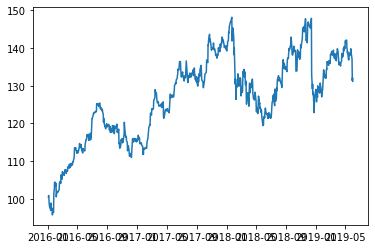

In [18]:
# draw line charts 
plt.plot(IBM["date"], IBM["close"])

In [25]:
# read all companies and retrieve stock
f = open("ticker_name.csv", "r")
f.readline()
ls = f.readlines()
for l in ls[520:]:
    try:
        ticker = l.split(",")[0]
        stock = get_historical_prices(ticker, datetime.datetime(2016,1,1), datetime.datetime(2019,6,1))
        stock.to_csv(ticker + '.csv')
    except:
        pass

In [ ]:
# return ticker
def get_ticker_by_compnayname(companyname):

    # set url for yahoo finance with filled in parameters
    url = "https://query2.finance.yahoo.com/v1/finance/search?q=%s&quotesCount=6&newsCount=0"%companyname
    response = requests.get(url).content
    try:
        return json.loads(response)["quotes"][0]["symbol"]
    except:
        return "not found"

In [ ]:
ticker = get_ticker_by_compnayname("AB Science S.A.")
print("ticker of AB Science S.A. is %s"%(ticker))

In [ ]:
# BPMC
plt.figure(figsize=(20,10))
BPMC = get_historical_prices("BPMC", datetime.datetime(2017,1,1), datetime.datetime(2019,1,1))
plt.plot(BPMC["date"], BPMC["close"], label="BPMC")
competitors = ["AB Science S.A.", "Allakos Inc.", "ARIAD Pharmaceuticals, Inc.", "AROG Pharmaceuticals, Inc.", "Deciphera Pharmaceuticals, LLC.", "Celldex Therapeutics, Inc.", "Takeda Pharmaceutical Company Limited"
               "AstraZeneca plc", "Boston Pharmaceuticals, Inc.", "Eisai Inc.", "Exelixis, Inc.", "GlaxoSmithKline plc", "Loxo Oncology, Inc.", "a wholly-owned subsidiary of Eli Lilly and Company", 
               "Mirati Therapeutics, Inc.", "Novartis AG, Pfizer Inc.", "Bristol-Myers Squibb Company", "nivolumab and Merck & Co., Inc.", "Incyte Corporation, Johnson & Johnson",
               "Abbisko Therapeutics Co.", "Ltd, AstraZeneca plc", "Bayer AG", "Celgene Corporation", "Eisai Inc.", "H3 Biomedicine Inc.", 
              ]

    
for com in competitors:
    ticker = get_ticker_by_compnayname(com)
    print("%s\t%s\n"%(ticker, com))
    if (ticker != "not found"):
        stock = get_historical_prices(ticker, datetime.datetime(2017,1,1), datetime.datetime(2019,1,1))
        plt.plot(stock["date"], stock["close"], label=ticker)

plt.legend(loc='upper right')


In [ ]:
# CLDX 
plt.figure(figsize=(20,10))
CLDX = get_historical_prices("CLDX", datetime.datetime(2017,1,1), datetime.datetime(2019,1,1))
plt.plot(BPMC["date"], BPMC["close"], label="CLDX")
competitors = ["AbbVie", "Astellas", "AstraZeneca", "Bristol-Myers Squibb", "Immunomedics", "Merck", "Nektar Therapeutics", "Novartis", "Pfizer", "Roche", "Tesaro"]

    
for com in competitors:
    ticker = get_ticker_by_compnayname(com)
    print("%s\t%s\n"%(ticker, com))
    if (ticker != "not found"):
        stock = get_historical_prices(ticker, datetime.datetime(2017,1,1), datetime.datetime(2019,1,1))
        plt.plot(stock["date"], stock["close"], label=ticker)

plt.legend(loc='upper right')



In [22]:
def NERTag(text):
        tokens = nltk.word_tokenize(text)
        tagged = nltk.pos_tag(tokens)
        entities = nltk.chunk.ne_chunk(tagged)
        dic = {}
        entityTypes = ['PERSON', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'WORK_OF_ART', 'EVENT']
        dic['ORG'] = []

        for e in entities:
            if 'ORG' in str(e):
                dic['ORG'] = dic['ORG'] + [str(e).split(' ')[1].split('/')[0],]

        print(dic['ORG'])

NERTag(sample_text)

['FDA', 'GIST', 'SM', 'KIT', 'FDA', 'GIST', 'GIST', 'Pfizer', 'GIST', 'GIST', 'PDGFRA', 'AB', 'ARIAD', 'AROG', 'LLC', 'MTC', 'ARIAD', 'AstraZeneca', 'GlaxoSmithKline', 'Company', 'RET', 'HCC', 'FGFR4', 'Merck', 'FDA', 'HCC', 'HCC', 'AstraZeneca', 'FOP', 'FOP', 'BioCryst']


entity types

-------------------------------------
PERSON	People, including fictional.
FAC	Buildings, airports, highways, bridges, etc.
ORG	Companies, agencies, institutions, etc.
GPE	Countries, cities, states.
LOC	Non-GPE locations, mountain ranges, bodies of water.
PRODUCT	Objects, vehicles, foods, etc. (Not services.)
EVENT	Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART	Titles of books, songs, etc.

text razor
https://www.textrazor.com/demo

build NER with Python
https://github.com/susanli2016/NLP-with-Python/blob/master/NER_sklearn.ipynb

train your won NER model
https://medium.com/swlh/stanford-corenlp-training-your-own-custom-ner-tagger-8119cc7dfc06